# Training Sample Analysis
In this notebook I analyse the differences between the 2018 and 2022 data samples used to train the BDTs. 

In [48]:
import numpy as np
import pandas as pd
import uproot as up
import matplotlib.pyplot as plt
import xgboost as xgb
from matplotlib.colors import LogNorm
import mplhep as hep
import hist
from hist import Hist
import boost_histogram as bh
hep.style.use(hep.style.ROOT)

## Load Data

In [2]:
column_names = [
    "straw1x", "straw1y", "trim5x", "trim5y", "mm2", "p",
    "vtxz", "vtxx", "vtxy",
    "thetax", "thetay", "rstraw1",
    "region", "isUpstreamTMVA",
    "pKaon", "gtk3x", "gtk3y", "gtkHitsWord",
]

df1 = pd.read_csv("./data/NewFW/BDT_Training_2022Data.txt", header=None)
df1.drop(18, inplace=True, axis=1)
df1.columns = column_names

df2 = pd.read_csv("./data/NewFW/BDT_Training_2018_Data.txt", header=None)
df2.drop(18, inplace=True, axis=1)
df2.columns = column_names

df1.head()

,straw1x,straw1y,trim5x,trim5y,mm2,p,vtxz,vtxx,vtxy,thetax,thetay,rstraw1,region,isUpstreamTMVA,pKaon,gtk3x,gtk3y,gtkHitsWord
0,-122.7510,51.0729,23.8575,-15.51530,0.050804,44.2019,113.754,3.39838,-1.32167,-0.001797,0.000812,229.701,2,1,74.3552,-11.106,2.2823,7
1,281.4070,-89.2130,-38.6429,1.74039,0.063823,42.4574,114.031,12.30490,-5.12479,0.003914,-0.001116,201.081,2,1,74.1868,0.194,0.7823,0
2,236.5090,-357.7780,-30.8118,255.85700,0.045600,15.6614,134.036,58.24070,9.41026,0.003271,-0.007510,382.509,2,1,74.9615,2.294,0.7823,0
3,-63.5324,200.7260,-2.8643,-18.73000,0.061105,42.0526,110.075,-4.04445,7.36871,-0.000746,0.002683,259.669,2,1,76.9224,-8.404,10.0798,7
4,-135.5340,341.5450,38.0602,-22.90730,0.030461,33.8756,111.642,3.46902,10.26000,-0.002128,0.004457,415.567,2,1,75.7102,-22.404,-1.0202,15


## Basic Analysis
Comparing all the 1D feature distributions.

In [60]:
features = [
    "straw1x", "straw1y", "trim5x", "trim5y", "rstraw1", "vtxz", "vtxx", "vtxy", "thetax", "thetay",
    "pKaon", "gtk3x", "gtk3y", "gtkHitsWord"
]

def plot_feature(feature, nbins=100, density=True, savefig=None):
    max_value = np.max([np.max(df1[feature].to_numpy()), np.max(df2[feature].to_numpy())])
    min_value = np.min([np.min(df1[feature].to_numpy()), np.min(df2[feature].to_numpy())])
    bin_edges = np.linspace(min_value, max_value, nbins + 1)

    h1, _ = np.histogram(df1[feature], bins=bin_edges)
    h2, _ = np.histogram(df2[feature], bins=bin_edges)

    plt.figure(figsize=(9,5))
    hep.histplot([h1, h2], bins=bin_edges, color=["blue", "red"], label=["2022", "2018"], density=density, yerr=True)
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.grid()
    plt.legend()
    if savefig != None:
        plt.savefig(savefig)
    plt.show()

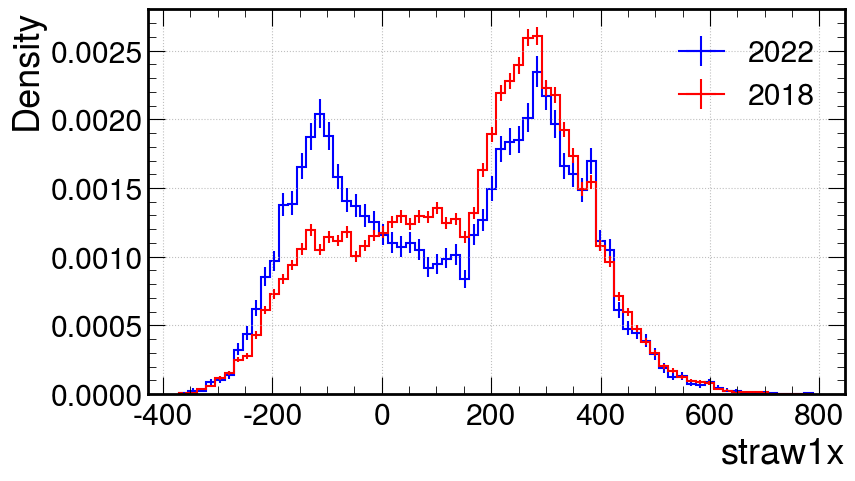

In [62]:
plot_feature("straw1x", nbins=70, savefig="plots/straw1x_2018_vs_2022.pdf")

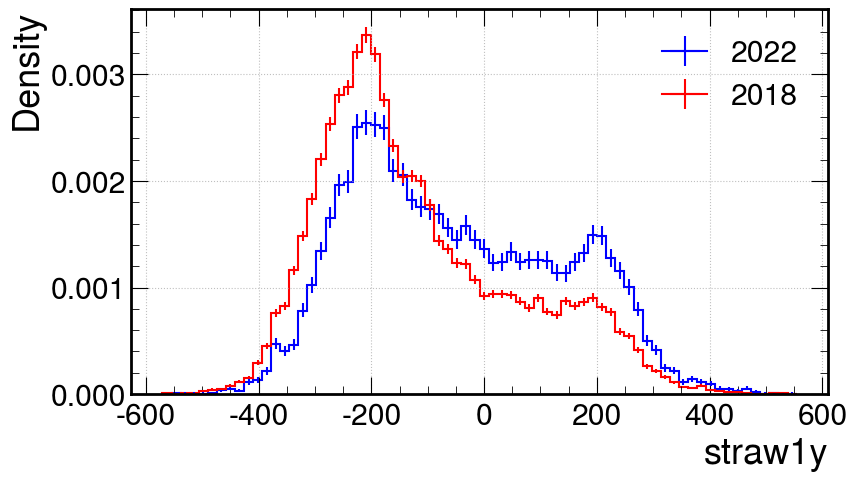

In [63]:
plot_feature("straw1y", nbins=70, savefig="plots/straw1y_2018_vs_2022.pdf")

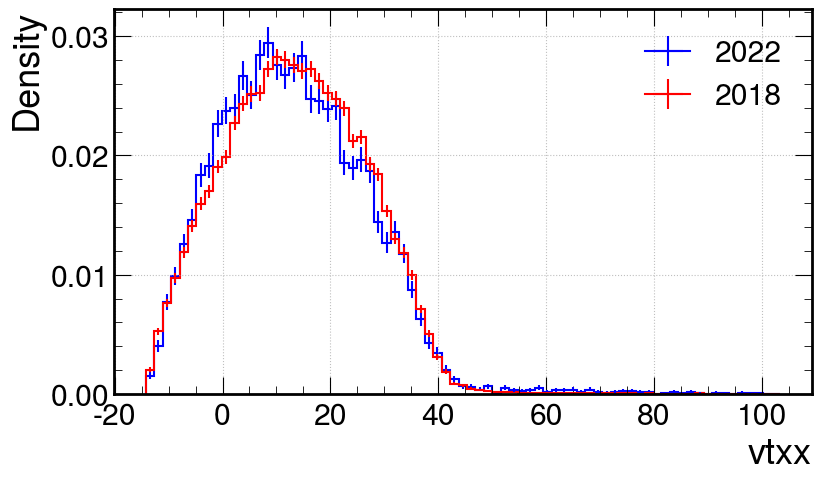

In [6]:
plot_feature("vtxx", nbins=75)

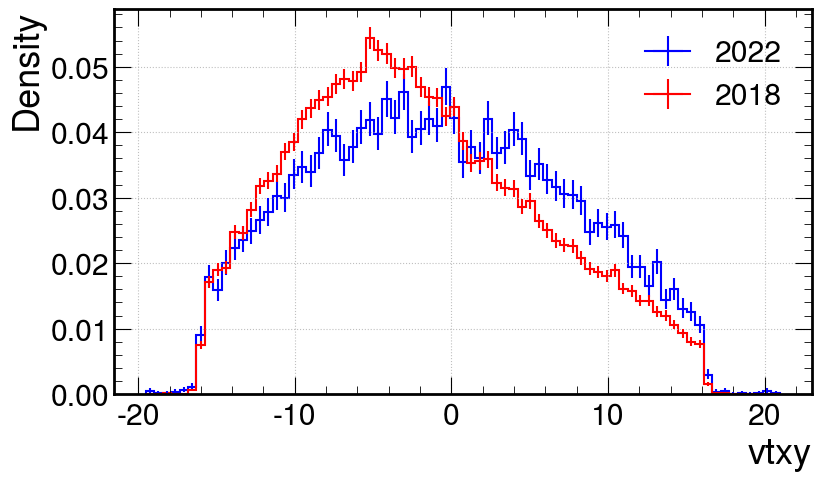

In [7]:
plot_feature("vtxy", nbins=75)

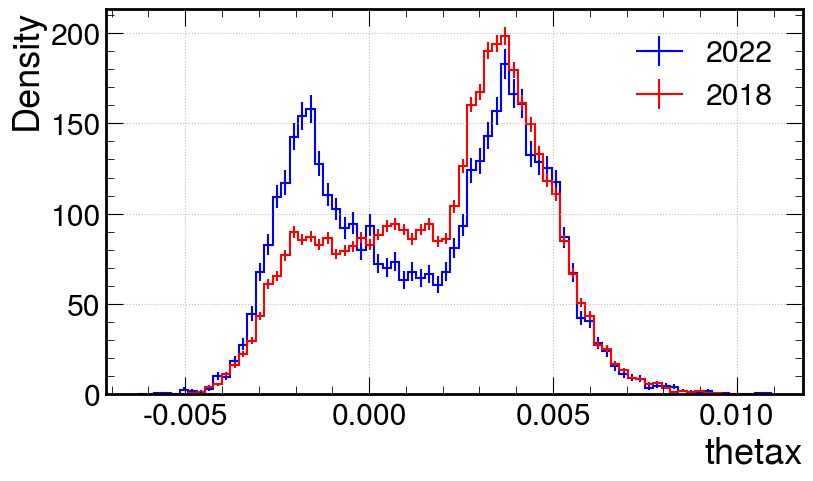

In [64]:
plot_feature("thetax", nbins=75, savefig="plots/thetax_2018_vs_2022.pdf")

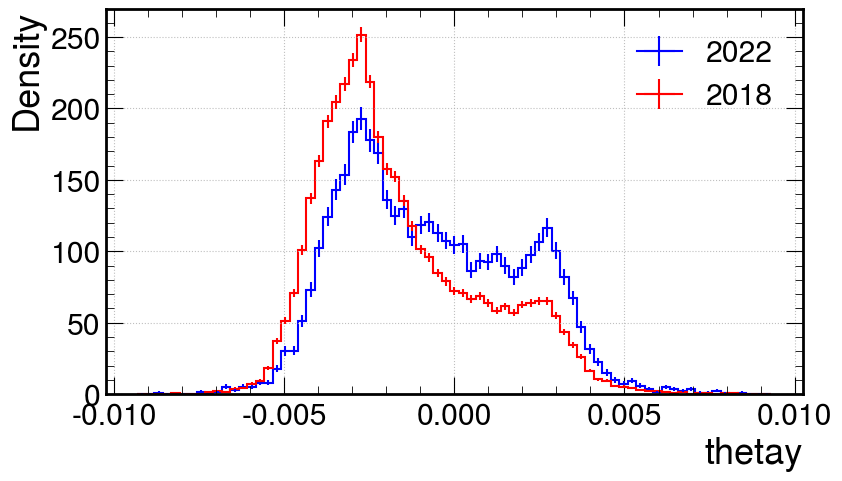

In [65]:
plot_feature("thetay", nbins=75, savefig="plots/thetay_2018_vs_2022.pdf")

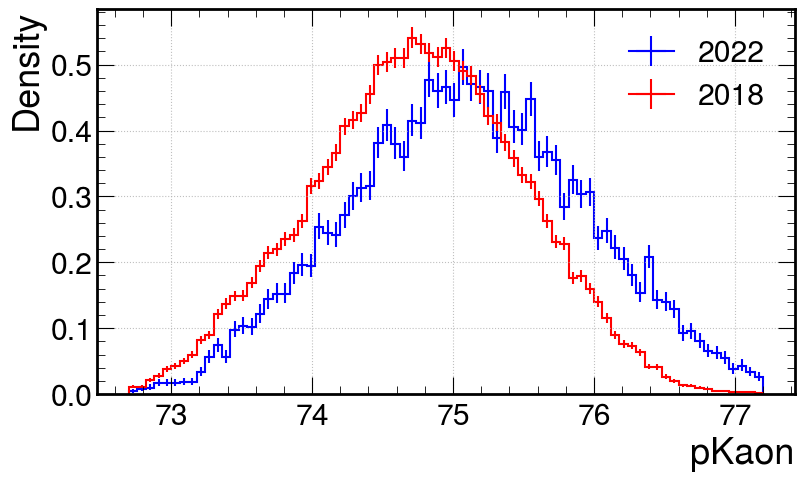

In [10]:
plot_feature("pKaon", nbins=75)

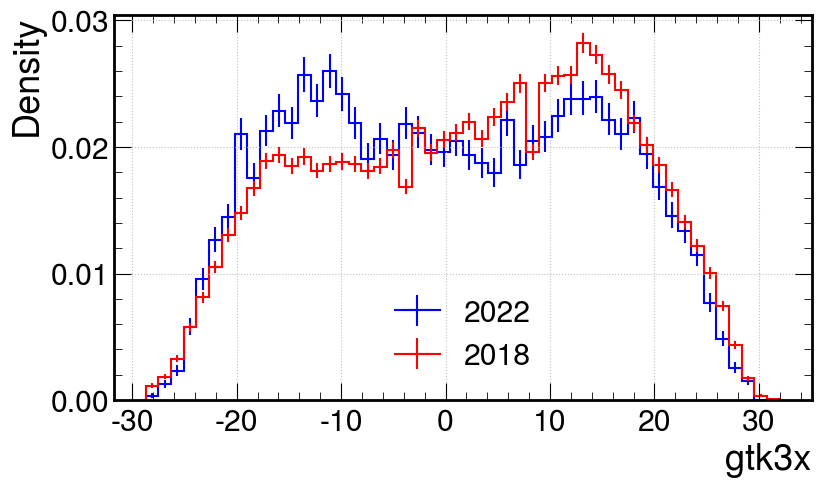

In [11]:
plot_feature("gtk3x", nbins=50)

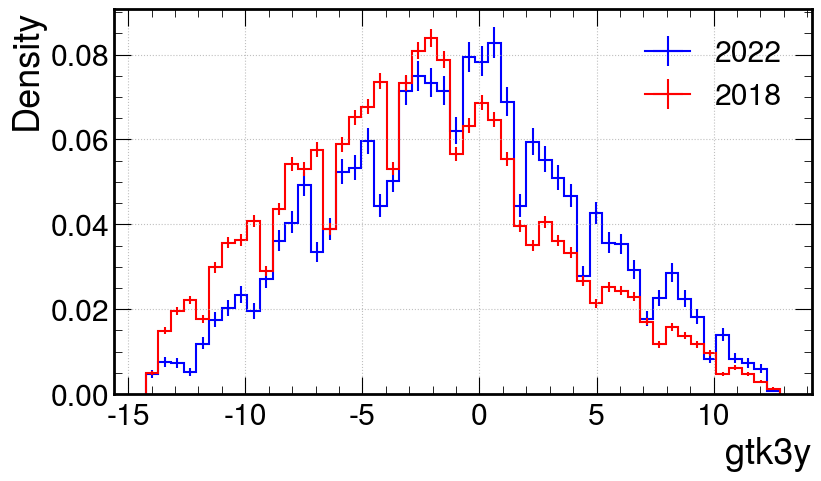

In [12]:
plot_feature("gtk3y", nbins=50)

We can see even in 1D that some of these features have significantly different distributions between 2018 and 2022. These could be due to minor selection differences but this is unlikely. Of note are:

1. The average beam momentum change
2. The $\theta_x$ and $\theta_y$ distributions
3. Positions at both the STRAW1 and GTK3.

## Targeted 2D Analysis

In [13]:
features_of_interest = ["pKaon", "thetax", "thetay", "straw1x", "straw1y", "gtk3x", "gtk3y"]

In [66]:
def plot_feature_2d(features, nbins=100, savefig=None):
    feature1, feature2 = features[0], features[1]

    max_value1 = np.max([np.max(df1[feature1].to_numpy()), np.max(df2[feature1].to_numpy())])
    min_value1 = np.min([np.min(df1[feature1].to_numpy()), np.min(df2[feature1].to_numpy())])
    max_value2 = np.max([np.max(df1[feature2].to_numpy()), np.max(df2[feature2].to_numpy())])
    min_value2 = np.min([np.min(df1[feature2].to_numpy()), np.min(df2[feature2].to_numpy())])
    
    bin_edges1 = np.linspace(min_value1, max_value1, nbins + 1)
    bin_edges2 = np.linspace(min_value2, max_value2, nbins + 1)
    bin_edges = (bin_edges1, bin_edges2)

    h1, binsx, binsy = np.histogram2d(df1[feature1], df1[feature2], bins=bin_edges, density=True)
    h2, binsx, binsy = np.histogram2d(df2[feature1], df2[feature2], bins=bin_edges, density=True)

    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    hep.hist2dplot(h1, xbins=binsx, ybins=binsy, ax=ax[0], label="2022", cmap="jet", norm=LogNorm())
    hep.hist2dplot(h2, xbins=binsx, ybins=binsy, ax=ax[1], label="2018", cmap="jet", norm=LogNorm())
    ax[0].set_xlabel(feature1)
    ax[1].set_xlabel(feature1)
    ax[0].set_ylabel(feature2)
    ax[1].set_ylabel(feature2)
    ax[0].grid()
    ax[1].grid()
    ax[0].set_title("2022")
    ax[1].set_title("2018")
    plt.tight_layout()
    if savefig:
        plt.savefig(savefig)
    plt.show()

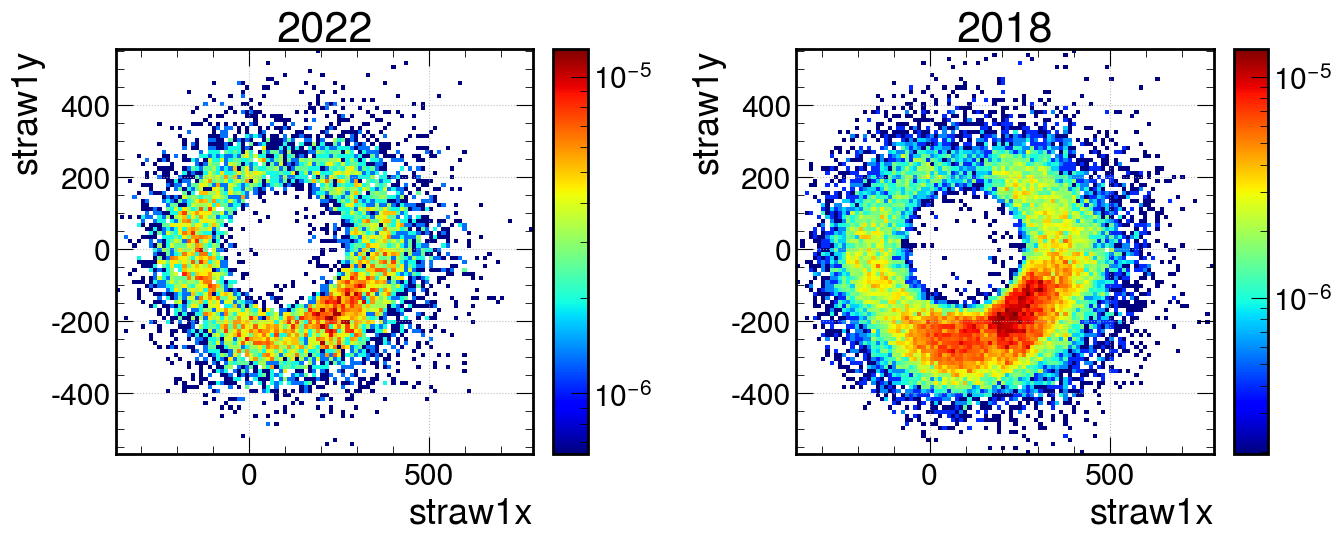

In [67]:
plot_feature_2d(["straw1x", "straw1y"], savefig="plots/straw1_x_vs_y_2022_and_2018.pdf")

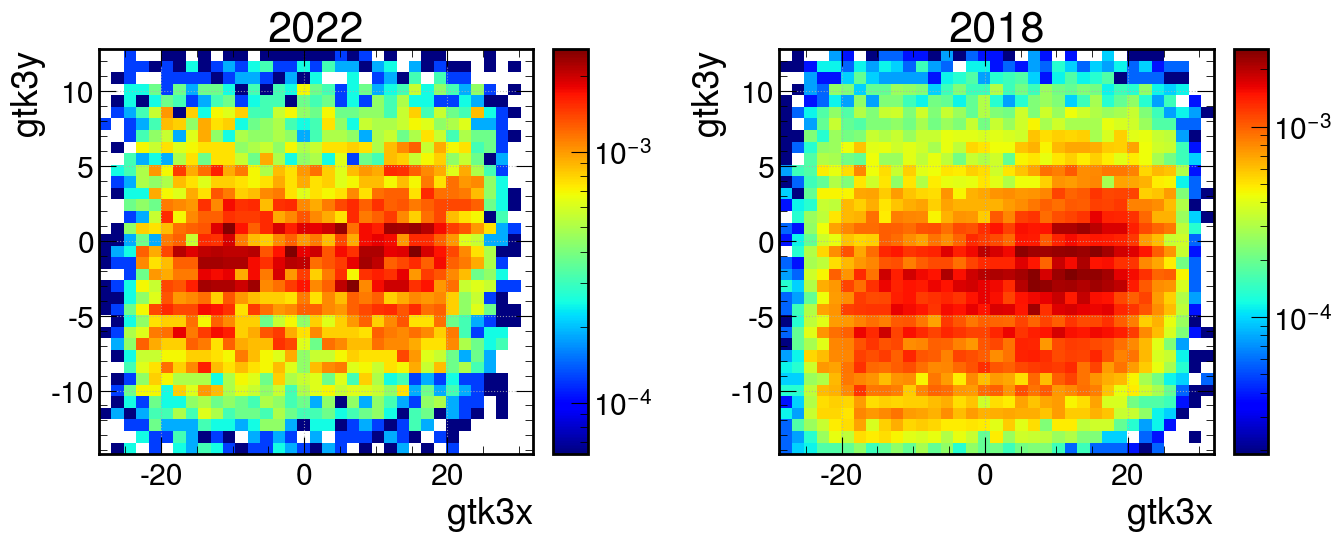

In [34]:
plot_feature_2d(["gtk3x", "gtk3y"], nbins=35)

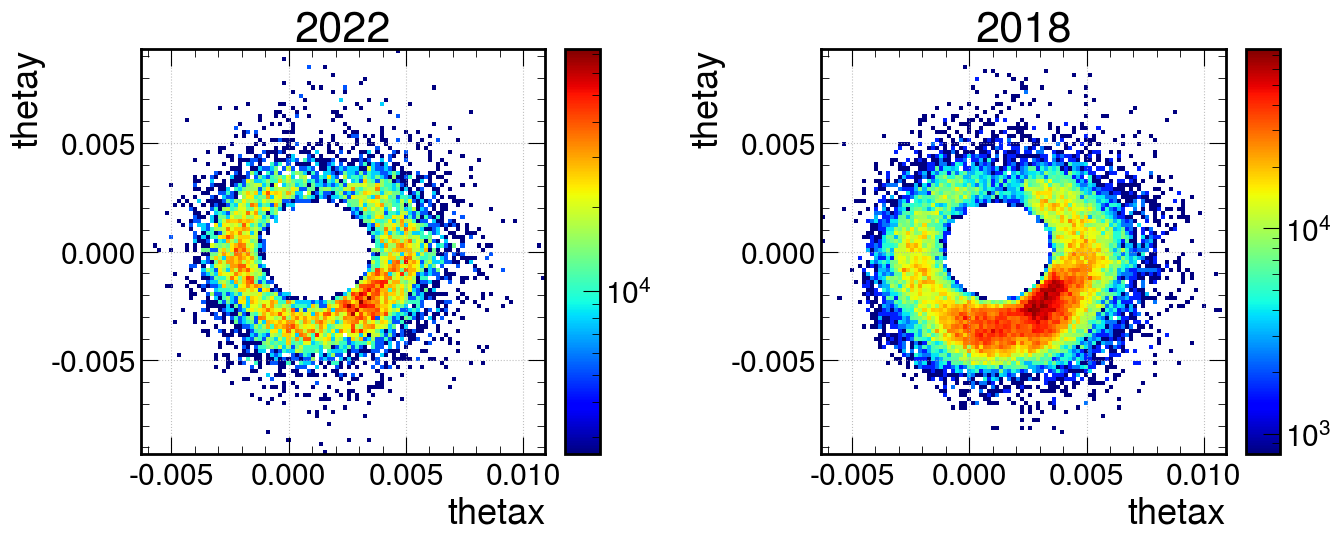

In [68]:
plot_feature_2d(["thetax", "thetay"], nbins=100, savefig="plots/theta_x_vs_y_2022_and_2018.pdf")

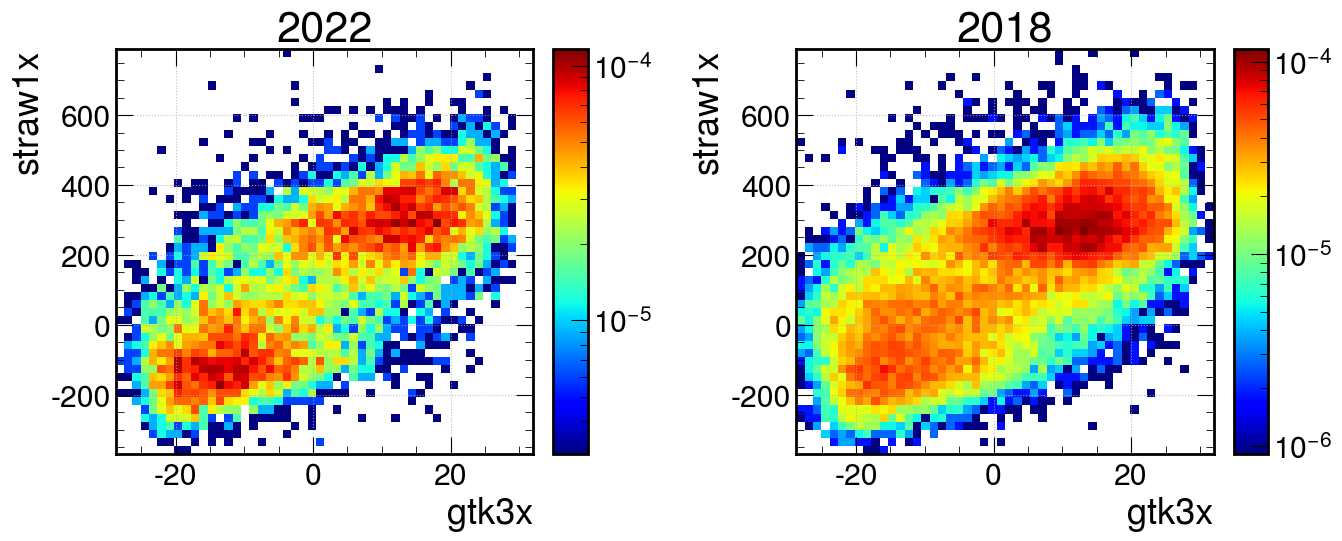

In [69]:
plot_feature_2d(["gtk3x", "straw1x"], nbins=50, savefig="plots/gtk3x_vs_straw1x_2022_and_2018.pdf")

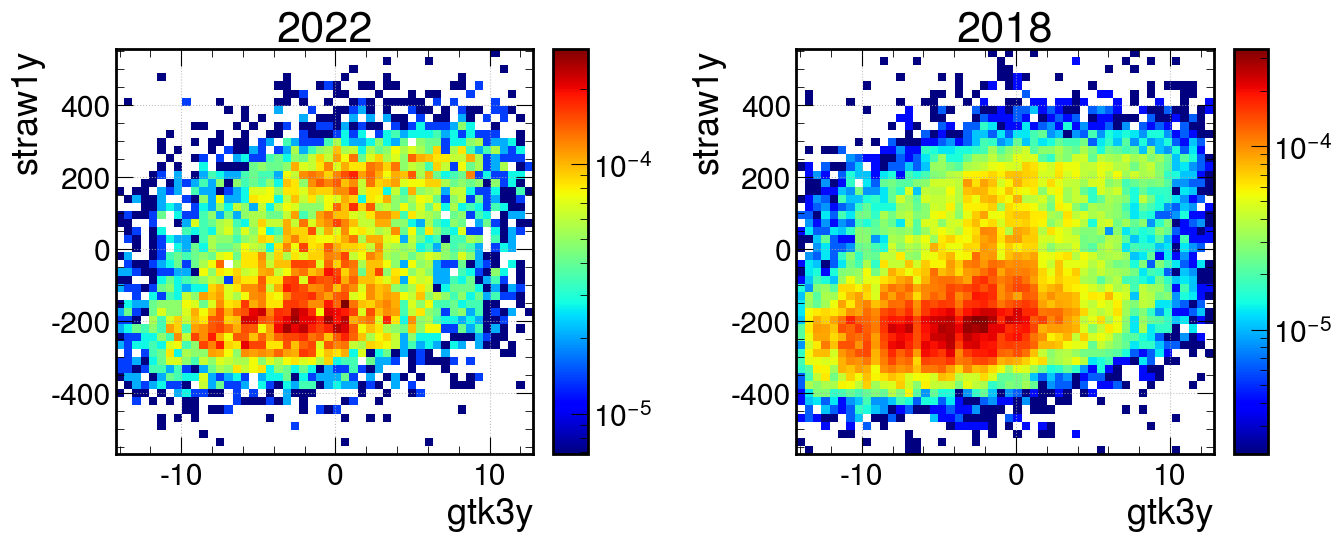

In [40]:
plot_feature_2d(["gtk3y", "straw1y"], nbins=50)

We see some slightly different spatial distributions at STRAW1 and GTK3 (likely highly correlated). I then made the peculiar STRAW1x vs GTK3x and similar for y. We get a sort of double peaked distribution in 2022 but the peak is much less pronounced in 2018.

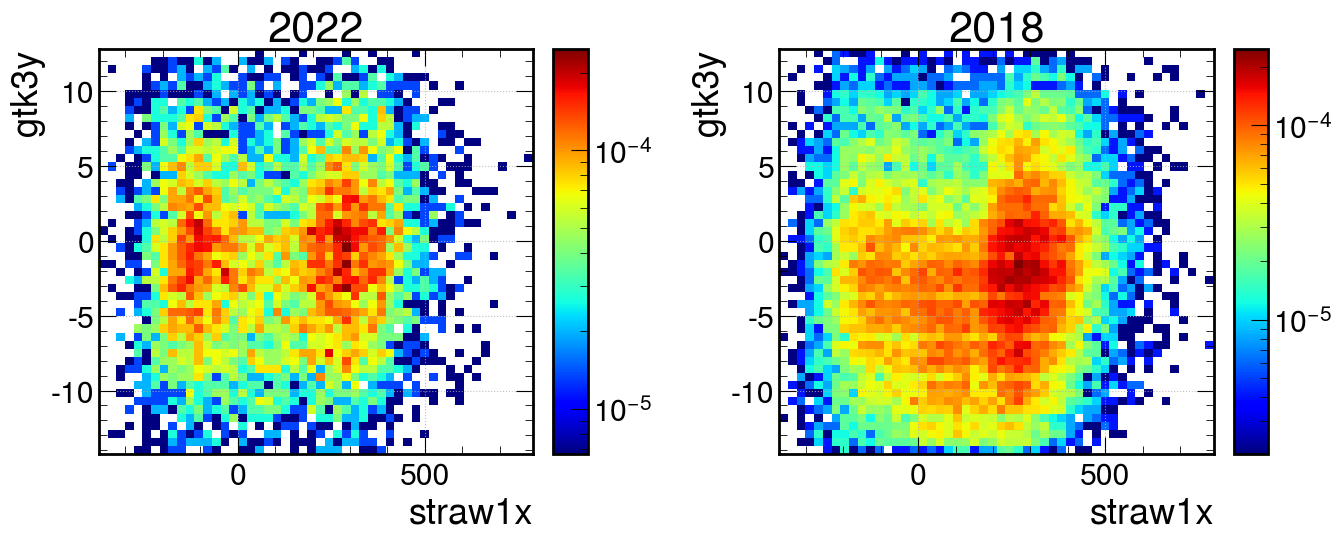

In [70]:
plot_feature_2d(["straw1x", "gtk3y"], nbins=50, savefig="plots/straw1x_vs_gtk3y_2022_and_2018.pdf")

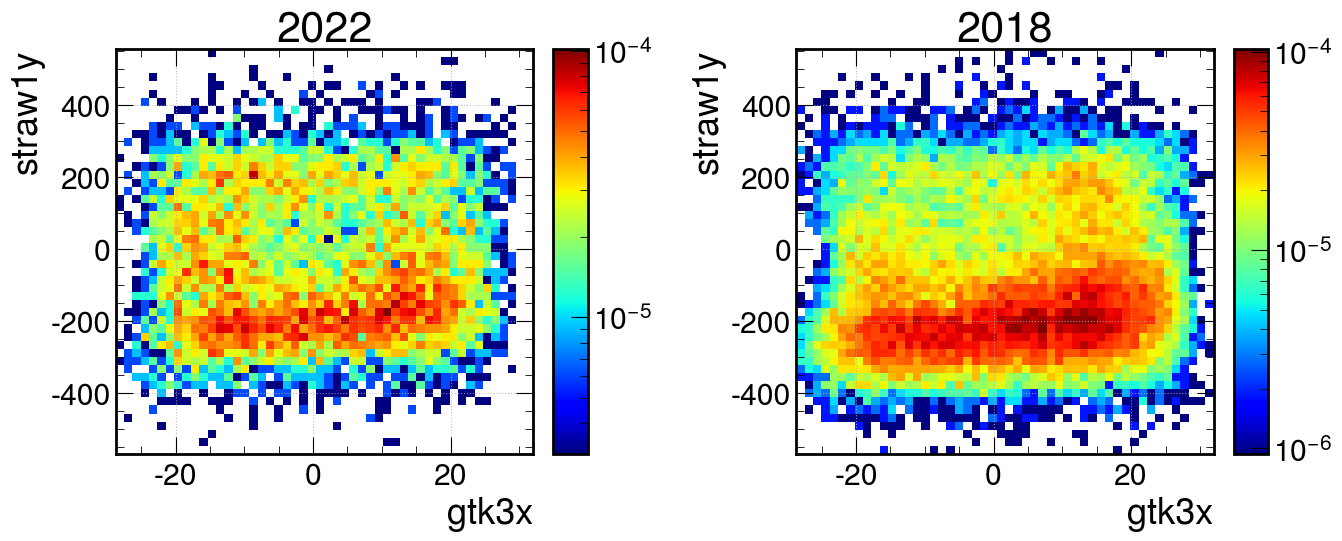

In [45]:
plot_feature_2d(["gtk3x", "straw1y"], nbins=50)

In [46]:
df1[features].describe()

,straw1x,straw1y,trim5x,trim5y,rstraw1,vtxz,vtxx,vtxy,thetax,thetay,pKaon,gtk3x,gtk3y,gtkHitsWord
count,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000,11929.000000
mean,121.731648,-49.934384,-3.432580,6.839168,277.559156,112.802750,13.173801,-0.803664,0.001528,-0.000697,75.093919,0.559941,-1.015530,40.655042
std,210.158112,186.001307,34.220276,36.906320,68.063279,5.106856,13.568658,8.019575,0.002866,0.002569,0.835945,13.838145,5.430868,59.891241
min,-370.361000,-543.403000,-511.685000,-489.484000,73.720000,110.000000,-14.235200,-19.519900,-0.005707,-0.009308,72.704000,-28.506000,-14.250000,0.000000
25%,-76.195300,-201.691000,-27.067800,-16.347400,229.062000,110.678000,3.086960,-7.196750,-0.001223,-0.002776,74.511300,-11.461000,-4.865200,0.000000
50%,146.066000,-79.964500,-5.597090,11.737300,269.968000,111.635000,12.244700,-1.098450,0.001931,-0.001054,75.091500,0.407200,-0.969900,7.000000
75%,296.516000,101.438000,21.962900,26.444900,314.632000,113.160000,22.021800,5.315670,0.003952,0.001364,75.676600,12.413200,2.641500,85.000000
max,789.065000,554.187000,424.006000,482.195000,689.610000,169.249000,100.054000,20.621800,0.010941,0.009318,77.191200,29.327600,12.549800,255.000000


In [47]:
df2[features].describe()

,straw1x,straw1y,trim5x,trim5y,rstraw1,vtxz,vtxx,vtxy,thetax,thetay,pKaon,gtk3x,gtk3y,gtkHitsWord
count,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000,39118.000000
mean,155.561078,-116.592277,-7.713743,14.539628,283.199822,112.312816,13.597241,-2.153708,0.001995,-0.001607,74.751317,2.274204,-2.580816,51.688686
std,194.339124,175.302573,27.691351,26.509462,69.597455,3.386051,12.929105,7.561807,0.002626,0.002374,0.743744,13.807620,5.460854,69.335388
min,-368.713000,-570.372000,-533.233000,-543.162000,71.426300,110.000000,-14.165300,-18.754100,-0.006302,-0.008312,72.700800,-28.702700,-13.970100,0.000000
25%,3.203028,-244.516750,-28.705675,-0.258261,231.714750,110.631000,3.934132,-7.968623,-0.000113,-0.003345,74.244625,-9.351500,-6.534850,0.000000
50%,194.987500,-163.124000,-12.162550,18.690650,275.006500,111.495000,13.304250,-2.949440,0.002594,-0.002238,74.761800,3.428600,-2.781650,6.000000
75%,302.430500,-8.940133,13.818900,31.144400,323.278750,112.985750,22.936275,3.100230,0.003986,-0.000146,75.267975,13.770700,0.824000,102.000000
max,782.912000,551.267000,496.773000,424.401000,715.776000,169.678000,103.336000,20.978500,0.010618,0.008544,77.200000,32.000200,12.828100,238.000000


In [58]:
model = xgb.Booster()
model.load_model("./models/kaon7.xgb")

model_2018 = xgb.Booster()
model_2018.load_model("./models/kaon7_2018DPlus_v2.xgb")

<Figure size 1000x1000 with 0 Axes>

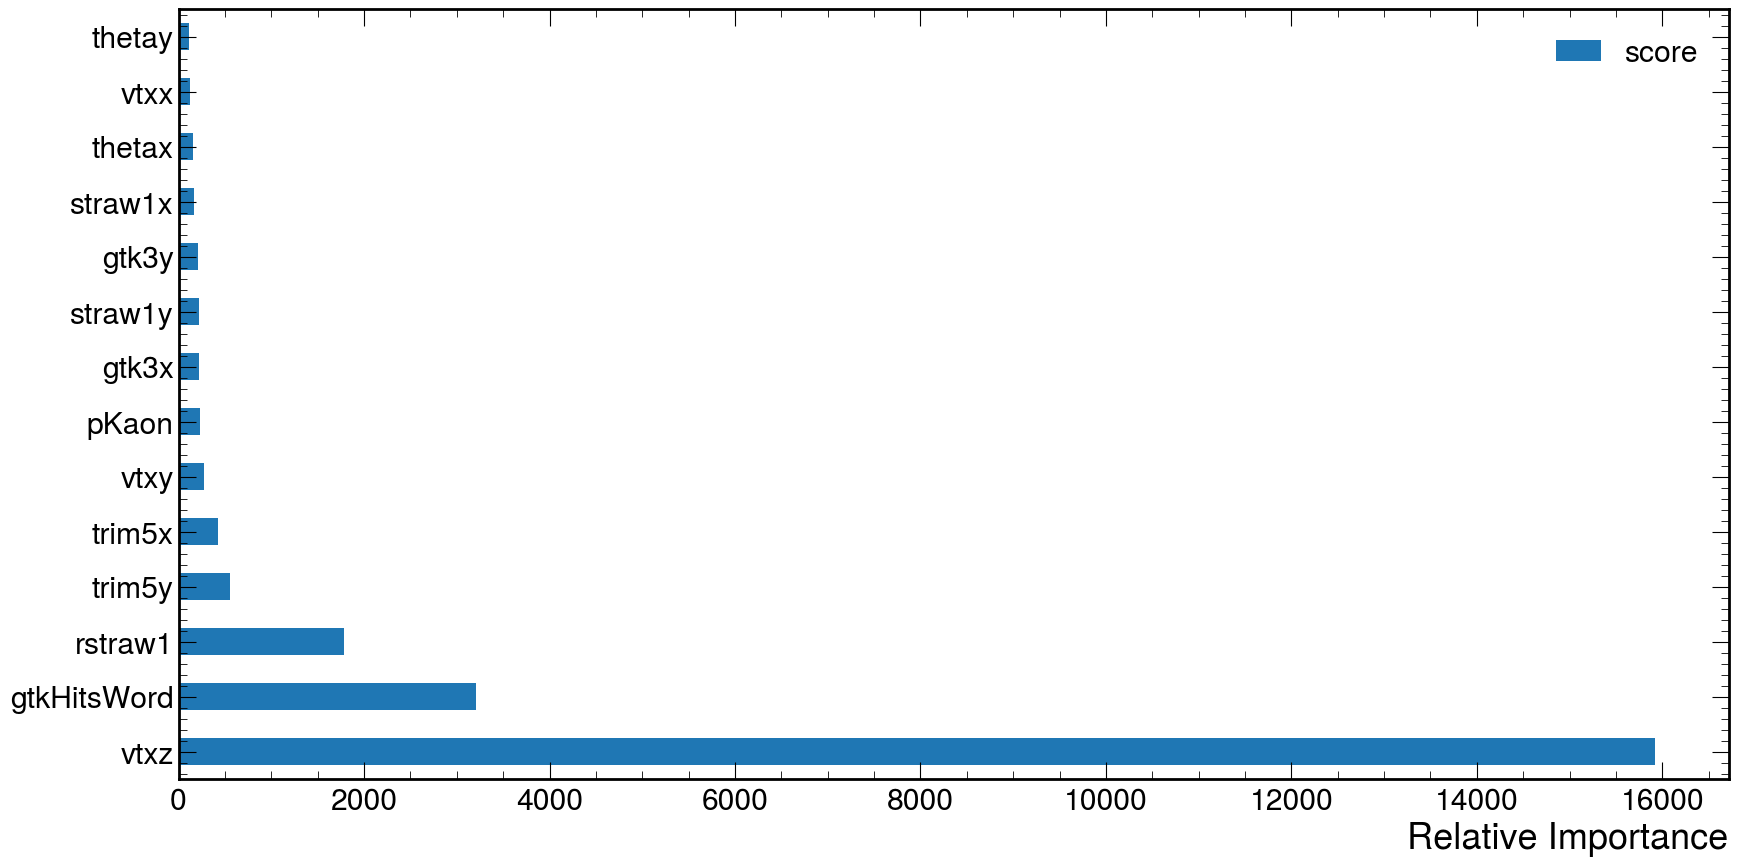

In [73]:
feature_important = model.get_score(importance_type='gain')
keys = list(feature_important.keys())
keys = [features[int(i[1:])] for i in keys]
values = list(feature_important.values())

fig = plt.figure()
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(features), columns="score").plot(kind='barh', figsize = (20,10))
plt.xlabel("Relative Importance")
plt.show()

<Figure size 1000x1000 with 0 Axes>

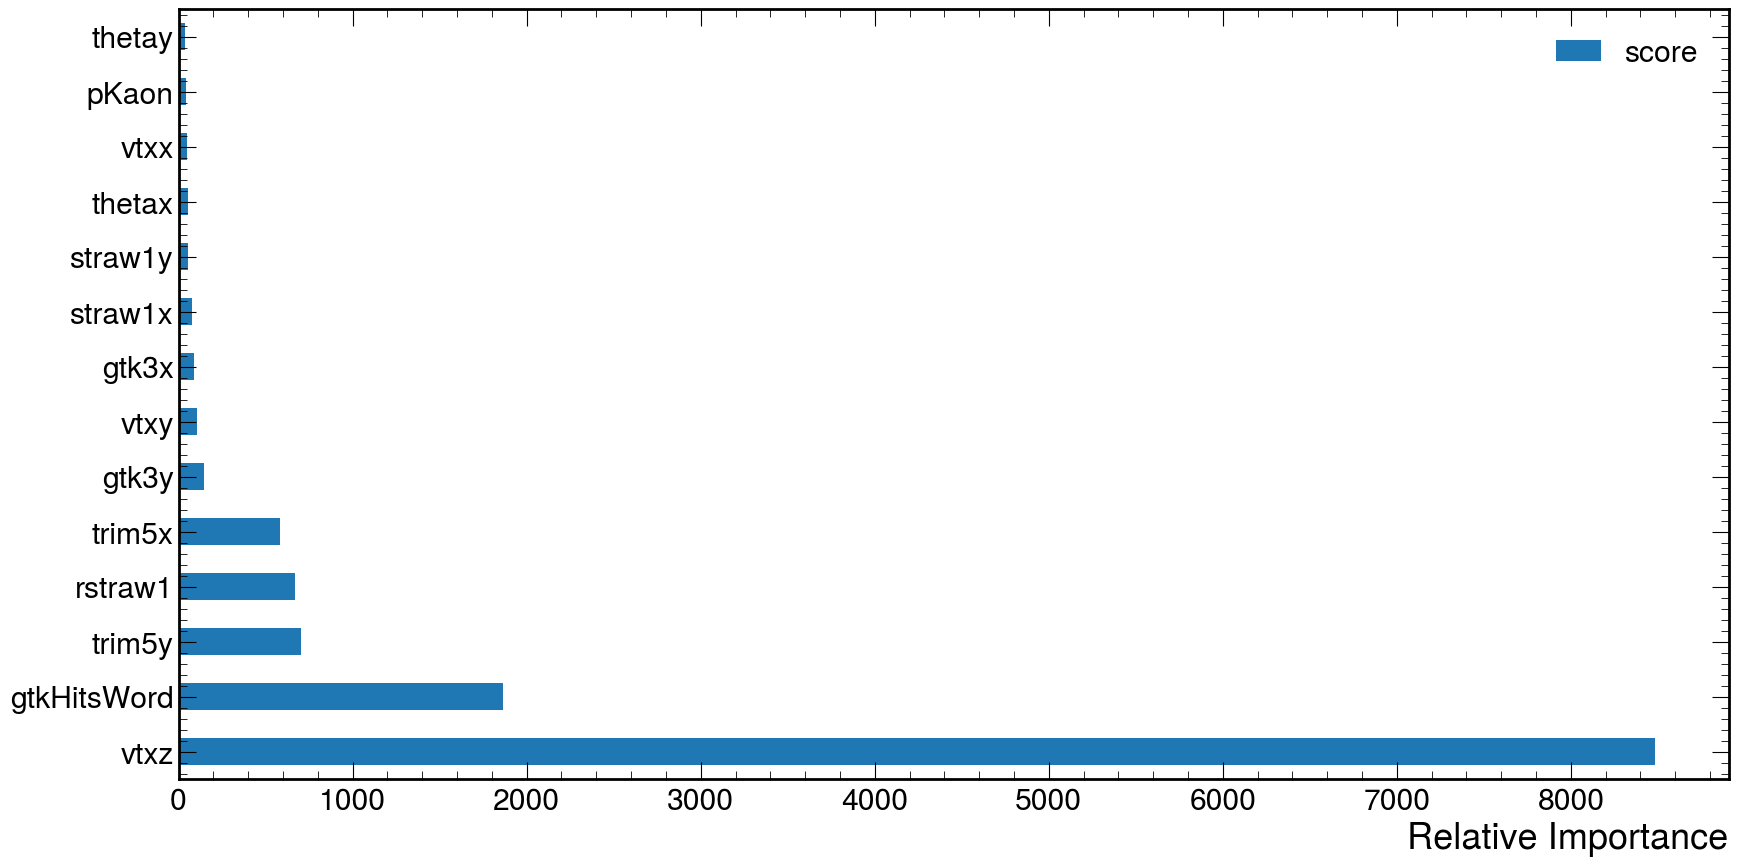

In [74]:
feature_important = model_2018.get_score(importance_type='gain')
keys = list(feature_important.keys())
keys = [features[int(i[1:])] for i in keys]
values = list(feature_important.values())

fig = plt.figure()
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(len(features), columns="score").plot(kind='barh', figsize = (20,10))
plt.xlabel("Relative Importance")
plt.show()